In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
from datetime import timedelta

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
# Set file path
file_path = 'C:\\Users\\alyar\\Downloads\\Dataset-B-MVP\\sales_data_sample.csv'
# Load and preprocess data
df = pd.read_csv(file_path, encoding='latin1')
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])
df['TOTAL_SALES'] = df['QUANTITYORDERED'] * df['PRICEEACH']

In [4]:
# Feature engineering
df['YEAR'] = df['ORDERDATE'].dt.year
df['MONTH'] = df['ORDERDATE'].dt.month
df['QUARTER'] = df['ORDERDATE'].dt.quarter
df['DAY_OF_WEEK'] = df['ORDERDATE'].dt.dayofweek
df['DAY_OF_MONTH'] = df['ORDERDATE'].dt.day

In [5]:
# Create customer features
customer_features = df.groupby('CUSTOMERNAME').agg(
    total_spent=('TOTAL_SALES', 'sum'),
    order_count=('ORDERNUMBER', 'nunique'),
    avg_order_value=('TOTAL_SALES', 'mean'),
    last_purchase=('ORDERDATE', 'max'),
    preferred_country=('COUNTRY', lambda x: x.mode()[0]),
    preferred_product=('PRODUCTLINE', lambda x: x.mode()[0]),
    avg_days_between=('ORDERDATE', lambda x: x.diff().dt.days.mean())
).reset_index()

In [6]:
# Calculate recency
current_date = df['ORDERDATE'].max() + timedelta(days=1)
customer_features['recency'] = (current_date - customer_features['last_purchase']).dt.days
customer_features = customer_features.drop(columns=['last_purchase'])

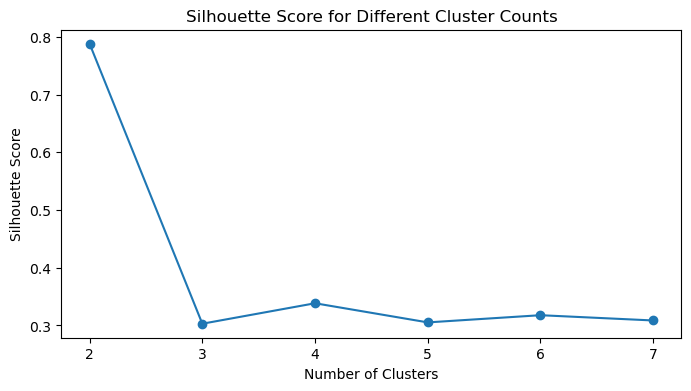

In [7]:
# Determine optimal clusters
from sklearn.metrics import silhouette_score

scaler_viz = StandardScaler()
scaled_data_viz = scaler_viz.fit_transform(customer_features[['total_spent', 'order_count', 'avg_order_value', 'recency']])

silhouette_scores = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data_viz)
    silhouette_scores.append(silhouette_score(scaled_data_viz, cluster_labels))

optimal_clusters = np.argmax(silhouette_scores) + 2  # +2 because range starts at 2

plt.figure(figsize=(8, 4))
plt.plot(range(2, 8), silhouette_scores, marker='o')
plt.title('Silhouette Score for Different Cluster Counts')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

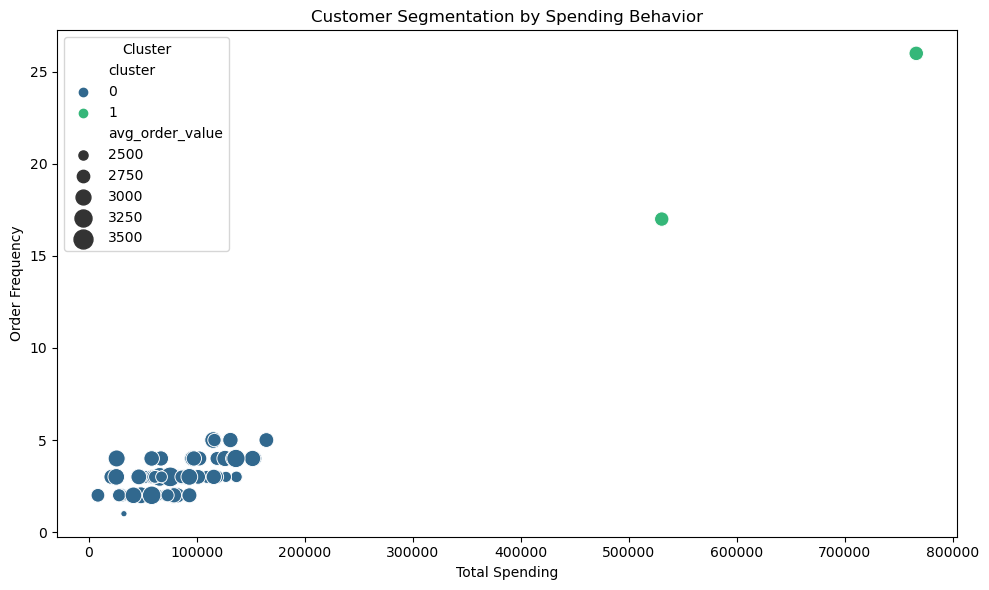

In [8]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
customer_features['cluster'] = kmeans.fit_predict(scaled_data_viz)

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='total_spent', 
    y='order_count', 
    hue='cluster', 
    data=customer_features, 
    palette='viridis',
    size='avg_order_value',
    sizes=(20, 200)
)
plt.title('Customer Segmentation by Spending Behavior')
plt.xlabel('Total Spending')
plt.ylabel('Order Frequency')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

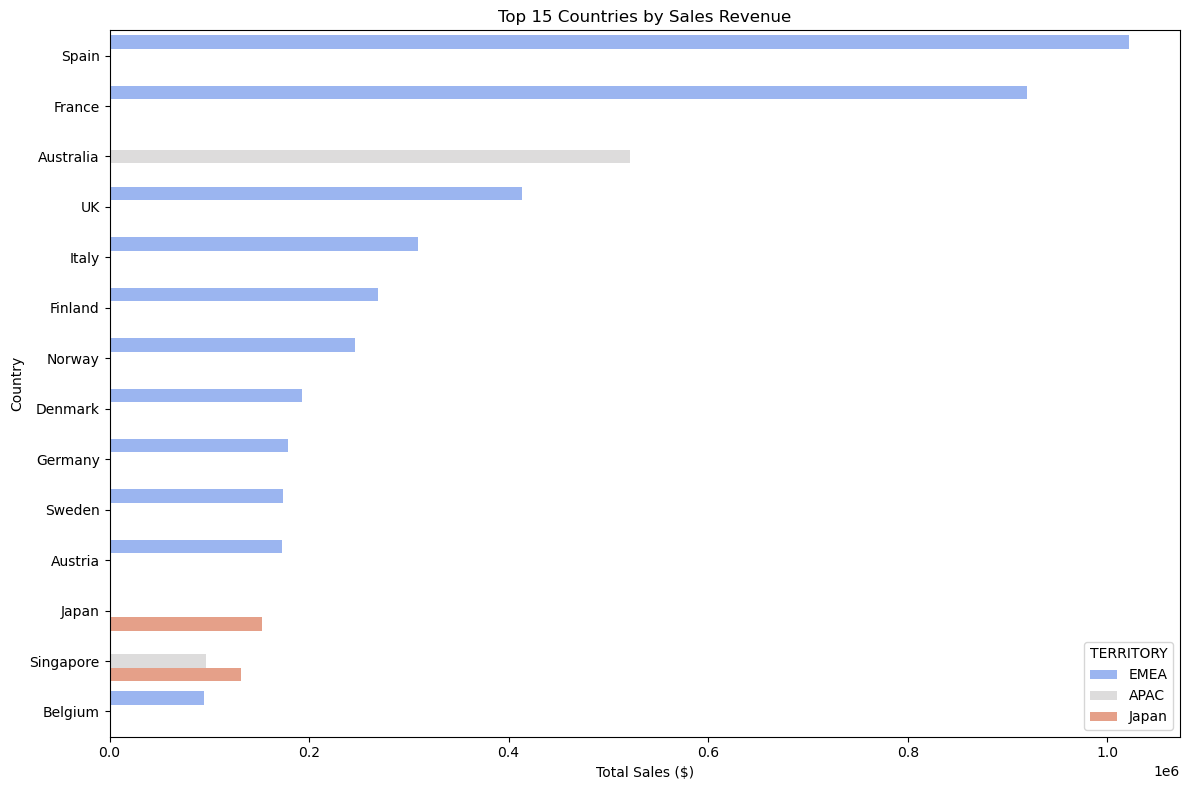

In [9]:
# Geographic Analysis
geo_data = df.groupby(['COUNTRY', 'TERRITORY']).agg(
    total_sales=('TOTAL_SALES', 'sum'),
    order_count=('ORDERNUMBER', 'nunique')
).reset_index().sort_values('total_sales', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(
    y='COUNTRY', 
    x='total_sales', 
    hue='TERRITORY', 
    data=geo_data.head(15),
    palette='coolwarm'
)
plt.title('Top 15 Countries by Sales Revenue')
plt.xlabel('Total Sales ($)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

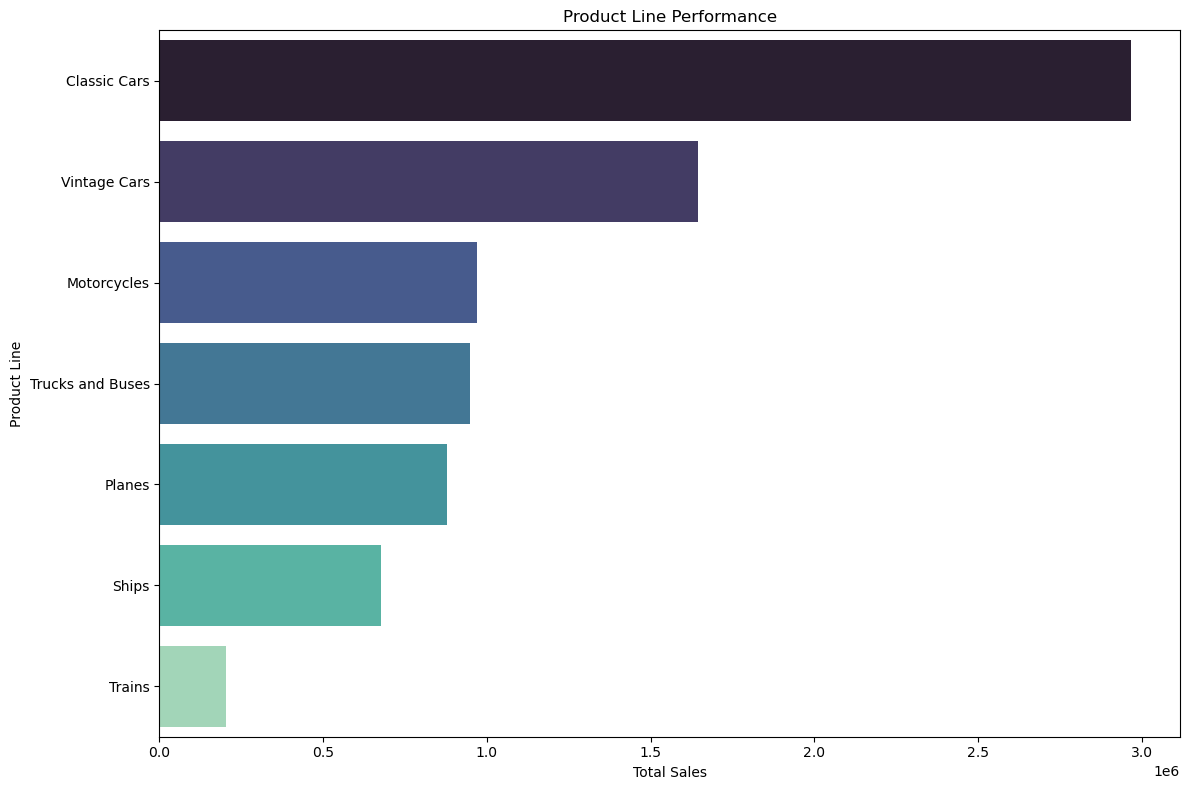

In [10]:
# Product Performance Analysis
product_performance = df.groupby(['PRODUCTLINE', 'COUNTRY']).agg(
    total_quantity=('QUANTITYORDERED', 'sum'),
    total_sales=('TOTAL_SALES', 'sum'),
    avg_price=('PRICEEACH', 'mean')
).reset_index().sort_values('total_sales', ascending=False)

underperforming = product_performance.groupby('PRODUCTLINE').agg(
    total_sales=('total_sales', 'sum')
).reset_index()
underperforming['sales_rank'] = underperforming['total_sales'].rank(ascending=True)
underperforming = underperforming[underperforming['sales_rank'] <= 3]

plt.figure(figsize=(12, 8))
sns.barplot(
    y='PRODUCTLINE',
    x='total_sales',
    data=product_performance.groupby('PRODUCTLINE').sum(numeric_only=True).reset_index().sort_values('total_sales', ascending=False),
    palette='mako'
)
plt.title('Product Line Performance')
plt.xlabel('Total Sales')
plt.ylabel('Product Line')
plt.tight_layout()
plt.show()

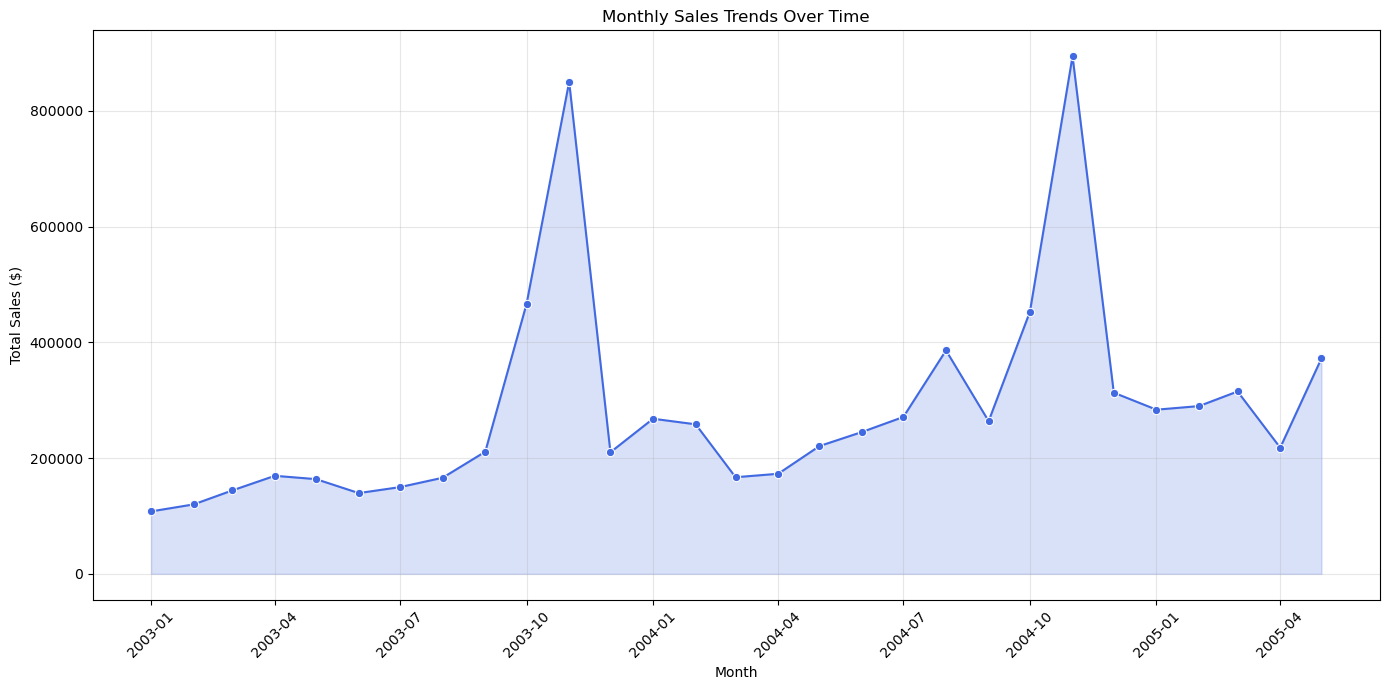

In [11]:
# Monthly Sales Trends
df['YEAR_MONTH'] = df['ORDERDATE'].dt.to_period('M')
monthly_trends = df.groupby('YEAR_MONTH').agg(
    monthly_sales=('TOTAL_SALES', 'sum'),
    order_count=('ORDERNUMBER', 'nunique')
).reset_index()
monthly_trends['YEAR_MONTH'] = monthly_trends['YEAR_MONTH'].dt.to_timestamp()

plt.figure(figsize=(14, 7))
sns.lineplot(
    x='YEAR_MONTH', 
    y='monthly_sales', 
    data=monthly_trends,
    marker='o',
    color='royalblue'
)
plt.fill_between(
    monthly_trends['YEAR_MONTH'], 
    monthly_trends['monthly_sales'], 
    alpha=0.2,
    color='royalblue'
)
plt.title('Monthly Sales Trends Over Time')
plt.xlabel('Month')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

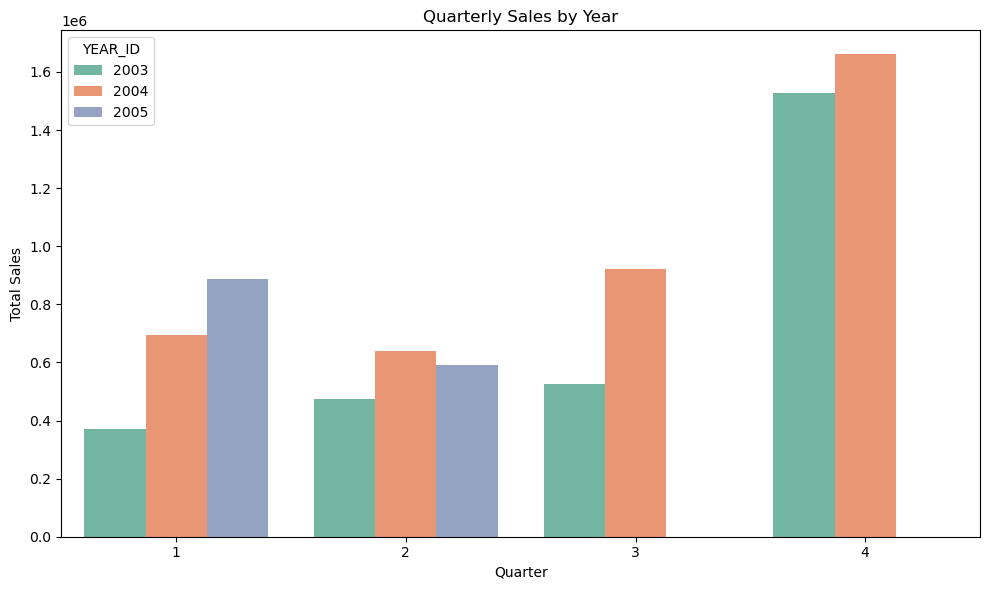

In [12]:
# Quarterly Analysis
df['QUARTER'] = df['ORDERDATE'].dt.quarter
df['YEAR_ID'] = df['ORDERDATE'].dt.year
quarterly_data = df.groupby(['YEAR_ID', 'QUARTER']).agg(
    total_sales=('TOTAL_SALES', 'sum')
).reset_index()

quarterly_data['YEAR_ID'] = quarterly_data['YEAR_ID'].astype(str)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='QUARTER',
    y='total_sales',
    hue='YEAR_ID',
    data=quarterly_data,
    palette='Set2'
)
plt.title('Quarterly Sales by Year')
plt.xlabel('Quarter')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

In [13]:
# 1. Customer segmentation insights
cluster_profiles = customer_features.groupby('cluster').agg({
    'total_spent': 'mean',
    'order_count': 'mean',
    'avg_order_value': 'mean',
    'recency': 'mean'
}).reset_index()
print("Cluster Profiles:\n", cluster_profiles.round(2))

# 2. Geographic insights
top_countries = geo_data.head(5)['COUNTRY'].tolist()
bottom_countries = geo_data.tail(5)['COUNTRY'].tolist()
print("Top Performing Countries:", top_countries)
print("Underperforming Countries:", bottom_countries)

# 3. Product insights
top_products = product_performance.head(5)
bottom_products = underperforming.head(3)['PRODUCTLINE'].tolist()
print("Top Performing Products:\n", top_products[['PRODUCTLINE', 'COUNTRY', 'total_sales']])
print("Underperforming Product Lines:", bottom_products)

# 4. Seasonal insights
quarterly_avg = quarterly_data.groupby('QUARTER')['total_sales'].mean()
best_quarter = quarterly_avg.idxmax()
worst_quarter = quarterly_avg.idxmin()
print(f"Best Performing Quarter: Q{best_quarter}")
print(f"Weakest Quarter: Q{worst_quarter}")

Cluster Profiles:
    cluster  total_spent  order_count  avg_order_value  recency
0        0     77712.27         2.93          2942.55   186.84
1        1    648391.12        21.50          2952.99     2.00
Top Performing Countries: ['Spain', 'France', 'Australia', 'UK', 'Italy']
Underperforming Countries: ['Singapore', 'Belgium', 'Switzerland', 'Philippines', 'Ireland']
Top Performing Products:
           PRODUCTLINE COUNTRY  total_sales
18       Classic Cars     USA   1015261.93
115      Vintage Cars     USA    645050.04
34        Motorcycles     USA    427488.21
14       Classic Cars   Spain    369361.76
97   Trucks and Buses     USA    340668.64
Underperforming Product Lines: ['Planes', 'Ships', 'Trains']
Best Performing Quarter: Q4
Weakest Quarter: Q2


In [14]:
# Create target variable for next purchase prediction
df_sorted = df.sort_values(['CUSTOMERNAME', 'ORDERDATE'])
df_sorted['next_purchase_date'] = df_sorted.groupby('CUSTOMERNAME')['ORDERDATE'].shift(-1)
df_sorted['days_to_next_purchase'] = (df_sorted['next_purchase_date'] - df_sorted['ORDERDATE']).dt.days

In [15]:
# Merge features with target
customer_data = customer_features.merge(
    df_sorted.groupby('CUSTOMERNAME')['days_to_next_purchase'].last().reset_index(),
    on='CUSTOMERNAME'
)

In [16]:
# Fill missing next purchase values with global average
global_avg_days = customer_data['days_to_next_purchase'].mean()
customer_data['days_to_next_purchase'] = customer_data['days_to_next_purchase'].fillna(global_avg_days)

In [17]:
# Encode categorical features
label_encoders = {}
categorical_cols = ['preferred_country', 'preferred_product']
for col in categorical_cols:
    le = LabelEncoder()
    customer_data[col] = le.fit_transform(customer_data[col])
    label_encoders[col] = le

In [18]:
# Prepare data for modeling
X = customer_data.drop(columns=['CUSTOMERNAME', 'days_to_next_purchase'])
y_days = customer_data['days_to_next_purchase']
y_country = customer_data['preferred_country']
y_product = customer_data['preferred_product']

# Split data
X_train, X_test, y_days_train, y_days_test, y_country_train, y_country_test, y_product_train, y_product_test = train_test_split(
    X, y_days, y_country, y_product, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# Train models
# Model 1: Predict next purchase date
days_model = RandomForestRegressor(n_estimators=100, random_state=42)
days_model.fit(X_train_scaled, y_days_train)
days_pred = days_model.predict(X_test_scaled)
days_rmse = np.sqrt(mean_squared_error(y_days_test, days_pred))


In [20]:
# Model 2: Predict preferred country
country_model = RandomForestClassifier(n_estimators=100, random_state=42)
country_model.fit(X_train_scaled, y_country_train)
country_pred = country_model.predict(X_test_scaled)
country_accuracy = accuracy_score(y_country_test, country_pred)

In [21]:
# Model 3: Predict preferred product
product_model = RandomForestClassifier(n_estimators=100, random_state=42)
product_model.fit(X_train_scaled, y_product_train)
product_pred = product_model.predict(X_test_scaled)
product_accuracy = accuracy_score(y_product_test, product_pred)

In [22]:
# Create campaign recommendations
def generate_campaign_recommendations(customer_data, models, scaler, label_encoders, days_threshold=30):
    # Prepare data for prediction
    X = customer_data.drop(columns=['CUSTOMERNAME', 'days_to_next_purchase'])
    
    # Scale features
    X_scaled = scaler.transform(X)
    
    # Make predictions
    days_pred = models['days_model'].predict(X_scaled)
    country_pred = models['country_model'].predict(X_scaled)
    product_pred = models['product_model'].predict(X_scaled)
    
    # Decode categorical predictions
    country_decoded = label_encoders['preferred_country'].inverse_transform(country_pred.astype(int))
    product_decoded = label_encoders['preferred_product'].inverse_transform(product_pred.astype(int))
    
    # Create recommendations dataframe
    recommendations = pd.DataFrame({
        'CUSTOMERNAME': customer_data['CUSTOMERNAME'],
        'PREDICTED_NEXT_PURCHASE_DAYS': days_pred,
        'RECOMMENDED_COUNTRY': country_decoded,
        'RECOMMENDED_PRODUCT': product_decoded,
        'TOTAL_SPENT': customer_data['total_spent'],
        'ORDER_COUNT': customer_data['order_count']
    })
    
    # Calculate campaign timing (7 days before predicted purchase)
    recommendations['CAMPAIGN_DATE'] = current_date + pd.to_timedelta(days_pred - 7, unit='D')
    
    # Segment customers by predicted purchase timing
    recommendations['PRIORITY_GROUP'] = np.where(
        days_pred <= days_threshold, 
        'HIGH PRIORITY (Within 30 days)', 
        'MEDIUM PRIORITY (Future opportunity)'
    )
    
    # Add value-based segmentation
    high_value_threshold = recommendations['TOTAL_SPENT'].quantile(0.8)
    recommendations['VALUE_SEGMENT'] = np.where(
        recommendations['TOTAL_SPENT'] > high_value_threshold,
        'HIGH VALUE',
        'STANDARD VALUE'
    )
    
    return recommendations.sort_values(by=['PRIORITY_GROUP', 'TOTAL_SPENT'], ascending=[True, False])

# Generate recommendations
models = {
    'days_model': days_model,
    'country_model': country_model,
    'product_model': product_model
}

campaign_recommendations = generate_campaign_recommendations(customer_data, models, scaler, label_encoders)


In [23]:
print(customer_data.columns)
print(models.keys())
print(label_encoders.keys())

Index(['CUSTOMERNAME', 'total_spent', 'order_count', 'avg_order_value',
       'preferred_country', 'preferred_product', 'avg_days_between', 'recency',
       'cluster', 'days_to_next_purchase'],
      dtype='object')
dict_keys(['days_model', 'country_model', 'product_model'])
dict_keys(['preferred_country', 'preferred_product'])


In [24]:
# Save models and recommendations
joblib.dump(days_model, 'next_purchase_model.pkl')
joblib.dump(country_model, 'country_model.pkl')
joblib.dump(product_model, 'product_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
campaign_recommendations.to_csv('campaign_recommendations.csv', index=False)

# Analyze recommendations
print("\n" + "="*50)
print("CAMPAIGN RECOMMENDATION INSIGHTS")
print("="*50)


CAMPAIGN RECOMMENDATION INSIGHTS


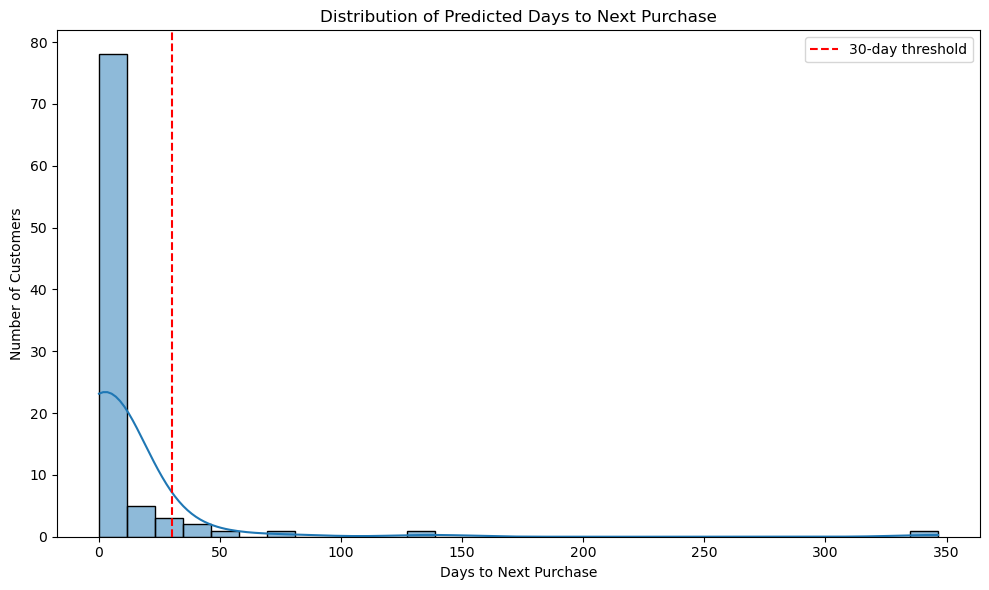

In [25]:
# 1. Campaign timing distribution
plt.figure(figsize=(10, 6))
sns.histplot(campaign_recommendations['PREDICTED_NEXT_PURCHASE_DAYS'], bins=30, kde=True)
plt.axvline(x=30, color='r', linestyle='--', label='30-day threshold')
plt.title('Distribution of Predicted Days to Next Purchase')
plt.xlabel('Days to Next Purchase')
plt.ylabel('Number of Customers')
plt.legend()
plt.tight_layout()
plt.savefig('purchase_timing_distribution.png', dpi=300)
plt.show()
plt.close()

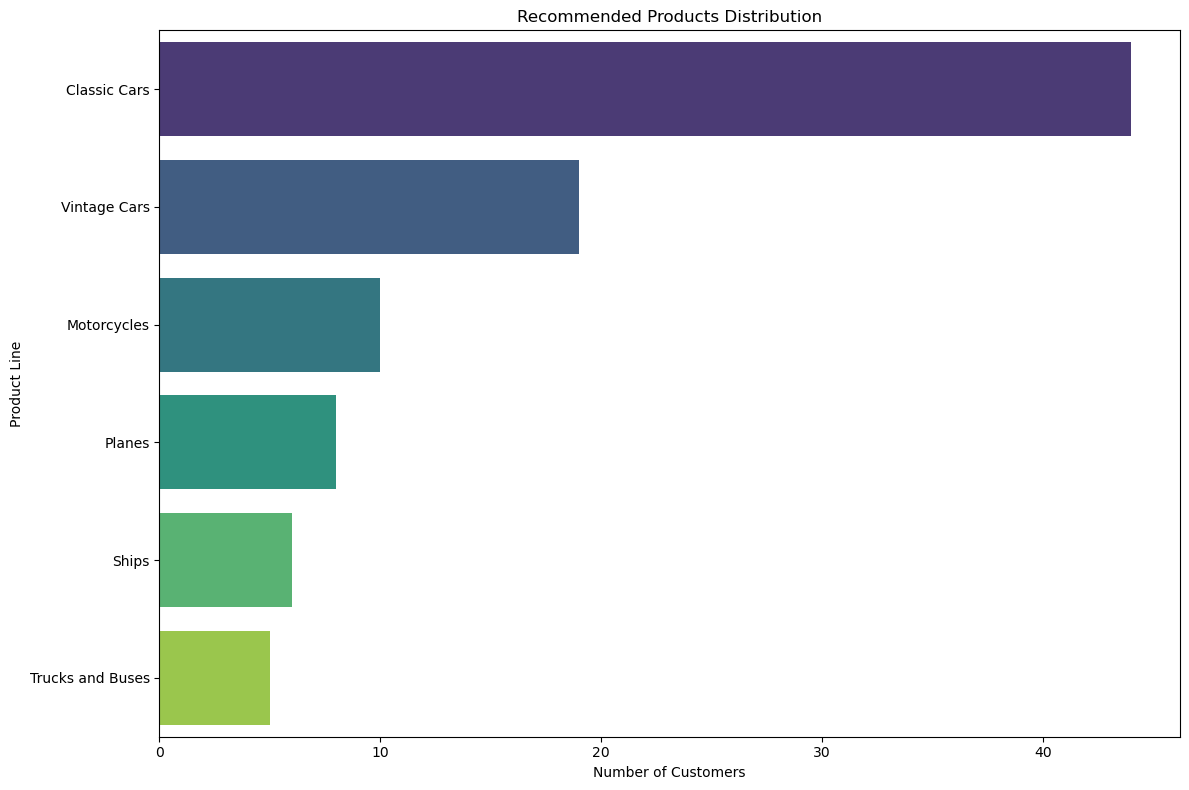

In [26]:
# 2. Recommended product distribution
product_dist = campaign_recommendations['RECOMMENDED_PRODUCT'].value_counts()
plt.figure(figsize=(12, 8))
sns.barplot(x=product_dist.values, y=product_dist.index, palette='viridis')
plt.title('Recommended Products Distribution')
plt.xlabel('Number of Customers')
plt.ylabel('Product Line')
plt.tight_layout()
plt.savefig('product_recommendations.png', dpi=300)
plt.show()
plt.close()

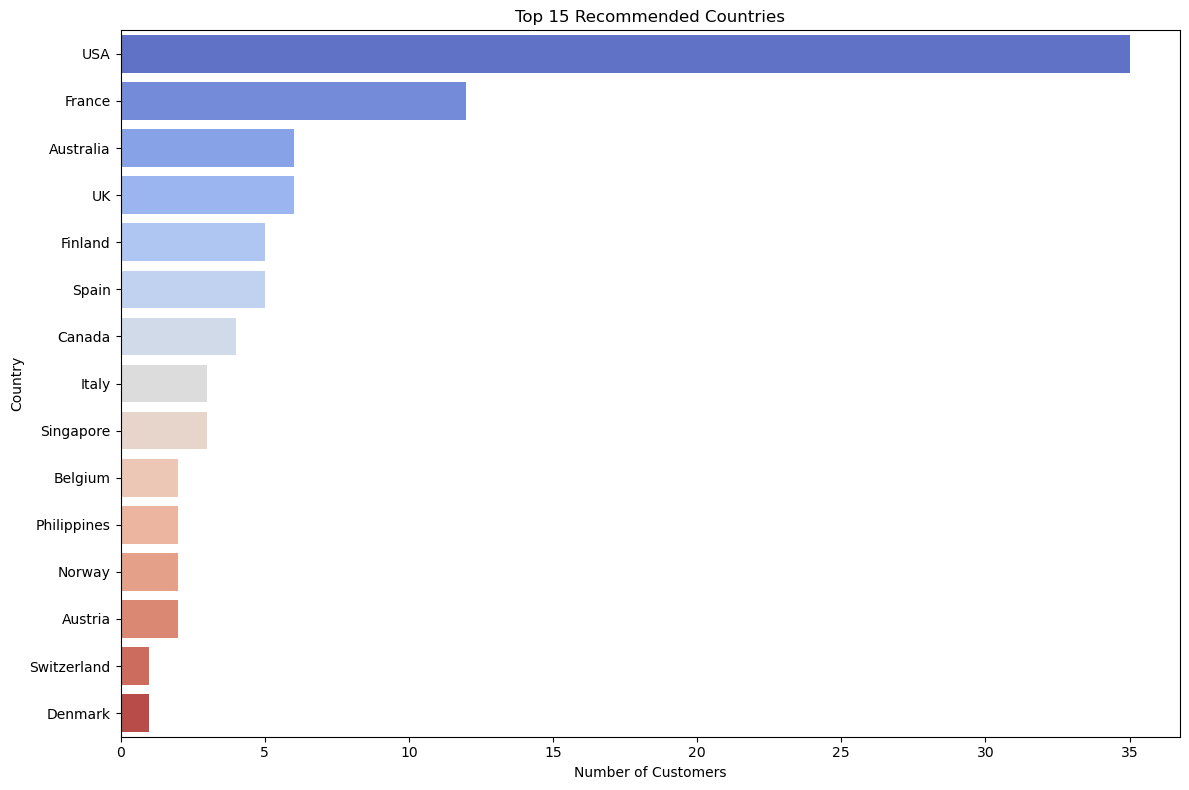

In [27]:
# 3. Recommended country distribution
country_dist = campaign_recommendations['RECOMMENDED_COUNTRY'].value_counts().head(15)
plt.figure(figsize=(12, 8))
sns.barplot(x=country_dist.values, y=country_dist.index, palette='coolwarm')
plt.title('Top 15 Recommended Countries')
plt.xlabel('Number of Customers')
plt.ylabel('Country')
plt.tight_layout()
plt.savefig('country_recommendations.png', dpi=300)
plt.show()
plt.close()

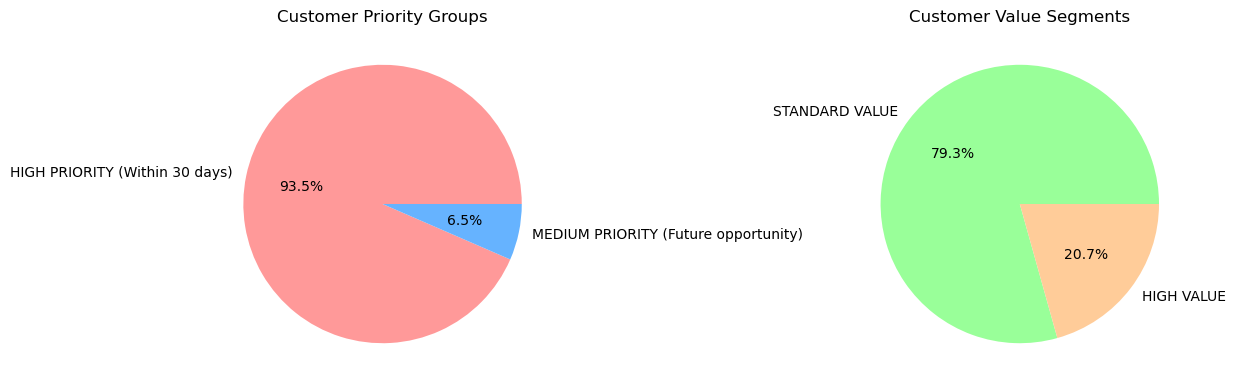

In [28]:
# 4. Customer segmentation
segment_counts = campaign_recommendations['PRIORITY_GROUP'].value_counts()
value_counts = campaign_recommendations['VALUE_SEGMENT'].value_counts()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
plt.title('Customer Priority Groups')

plt.subplot(1, 2, 2)
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=['#99ff99','#ffcc99'])
plt.title('Customer Value Segments')
plt.tight_layout()
plt.savefig('customer_segments.png', dpi=300)
plt.show() 
plt.close()

In [29]:
# Print key insights
high_priority = campaign_recommendations[campaign_recommendations['PRIORITY_GROUP'] == 'HIGH PRIORITY (Within 30 days)']
high_value_high_priority = high_priority[high_priority['VALUE_SEGMENT'] == 'HIGH VALUE']

print(f"\nModel Performance:")
print(f"- Next Purchase Days Prediction RMSE: {days_rmse:.2f} days")
print(f"- Country Prediction Accuracy: {country_accuracy:.2%}")
print(f"- Product Prediction Accuracy: {product_accuracy:.2%}")

print("\nCampaign Recommendations Summary:")
print(f"- Total customers: {len(campaign_recommendations)}")
print(f"- High priority customers (next 30 days): {len(high_priority)}")
print(f"- High value + high priority customers: {len(high_value_high_priority)}")
print(f"- Most recommended product: {product_dist.index[0]} ({product_dist.values[0]} customers)")
print(f"- Top recommended country: {country_dist.index[0]} ({country_dist.values[0]} customers)")

print("\nAction Plan:")
print("1. Focus immediately on HIGH PRIORITY customers:")
print(f"   - {len(high_priority)} customers predicted to purchase within 30 days")
print(f"   - Including {len(high_value_high_priority)} high-value customers")
print("   - Campaign timing: 7 days before predicted purchase date")
print("   - Use recommended product and country for targeting")

print("\n2. For MEDIUM PRIORITY customers:")
print("   - Schedule campaigns for future opportunities")
print("   - Develop nurture campaigns to accelerate purchase timing")
print("   - Focus on high-value customers first")

print("\n3. Geographic Strategy:")
print(f"   - Allocate resources to top countries: {', '.join(country_dist.index[:3])}")
print("   - Localize campaigns for each country's preferences")

print("\n4. Product Strategy:")
print(f"   - Prioritize {product_dist.index[0]} in campaigns")
print("   - Create bundles for complementary product lines")
print("   - Develop special offers for underperforming products")

print("\nRecommendations saved to 'campaign_recommendations.csv'")
print("Visualizations saved as PNG files")


Model Performance:
- Next Purchase Days Prediction RMSE: 21.69 days
- Country Prediction Accuracy: 57.89%
- Product Prediction Accuracy: 78.95%

Campaign Recommendations Summary:
- Total customers: 92
- High priority customers (next 30 days): 86
- High value + high priority customers: 15
- Most recommended product: Classic Cars (44 customers)
- Top recommended country: USA (35 customers)

Action Plan:
1. Focus immediately on HIGH PRIORITY customers:
   - 86 customers predicted to purchase within 30 days
   - Including 15 high-value customers
   - Campaign timing: 7 days before predicted purchase date
   - Use recommended product and country for targeting

2. For MEDIUM PRIORITY customers:
   - Schedule campaigns for future opportunities
   - Develop nurture campaigns to accelerate purchase timing
   - Focus on high-value customers first

3. Geographic Strategy:
   - Allocate resources to top countries: USA, France, Australia
   - Localize campaigns for each country's preferences

4. P